# **Intro M1**
In this notebook I set up semi-supervised VAE to predict cell type proportions from bulk data.
This is the original model structure (M1)
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportion, sample-id, and everything else (slack).
To enforce this disentanglement, there are classification losses on the cell-type and smaple_id embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.



The experimental set-up is as follows:
All data is from pbmc6k dataset.
Cells are sampled to generate 10 pesudobulks.
There are perturbed samples --> this means that for some samples we have mono14 cells instead of mono16 cells. 
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the labeled data (meaning each sample has a ground truth) and 8 samples with unlabeled data (ground truth proportions are not used in training.)




This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae



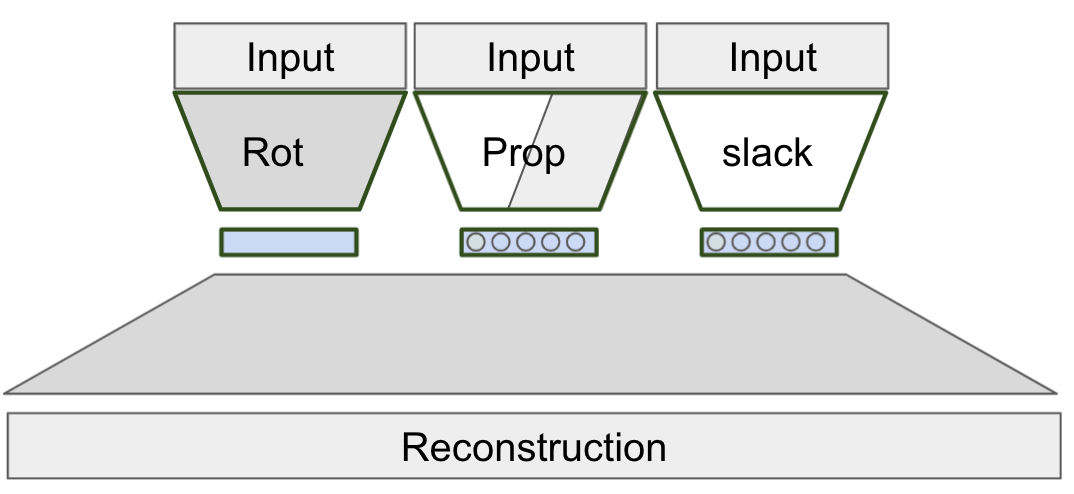

# **Imports**

In [1]:
import pandas as pd


In [2]:
import tensorflow as tf

In [3]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [4]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [5]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [6]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt"

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

num_genes = 7000

exp_id = "mono-kang"

# Set-up experimental variables

In [7]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 10

# number of patients/domains/samples expected
idx_range = range(0, 16)
n_tot_samples = 8 # 8 patients, 2 samples each

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [8]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id)
X_full.columns = gene_df

X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


In [9]:
np.sort(X_colmean)

array([0.0, 0.0, 0.0, ..., 805153.9733009709, 1589713.2582524272,
       1683341.556553398], dtype=object)

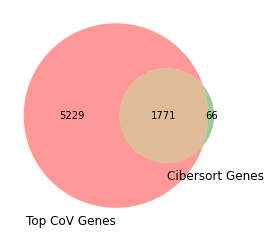

In [10]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [11]:
union_genes = np.union1d(gene_df, cibersort_genes)


In [12]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [13]:
X_full = X_full.loc[:,union_genes]


## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = StandardScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()





In [14]:
X_train

array([[165, 510, 8, ..., 0, 0, 0],
       [142, 932, 2, ..., 0, 0, 0],
       [506, 1584, 0, ..., 0, 0, 0],
       ...,
       [17, 296, 0, ..., 0, 0, 0],
       [21, 304, 0, ..., 0, 0, 0],
       [30, 365, 0, ..., 0, 0, 0]], dtype=object)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.127s...
[t-SNE] Computed neighbors for 17320 samples in 16.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for s

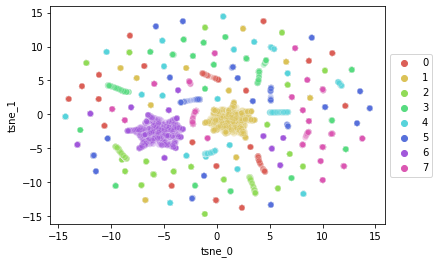

In [15]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **PCA Model Definition**

In [16]:
len(np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type != "bulk"))[0] )

4000

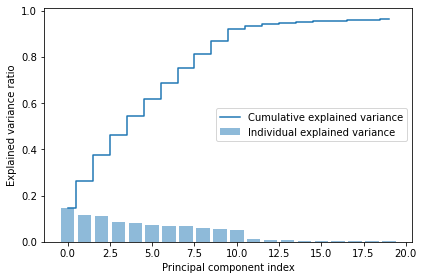

In [17]:
### get training data

idx_bulk_train = np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type == "bulk"))[0] 
X_temp = X_full[idx_bulk_train]

fit = PCA(n_components=20)
pca_results = fit.fit_transform(X_temp)

exp_var_pca = fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

## plot variance explained
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [18]:
Label_full.shape

(17320,)

In [19]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full

recon_idx = np.logical_and(meta_df.cell_prop_type == "realistic", meta_df.isTraining == "Test")
recon_idx = np.where(recon_idx)[0]


Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_temp[recon_idx]
label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the PCA to get the latent space
pca_proj = fit.transform(X_temp)
decoded_outputs = fit.inverse_transform(pca_proj)


(1200, 2)
(1200, 2)


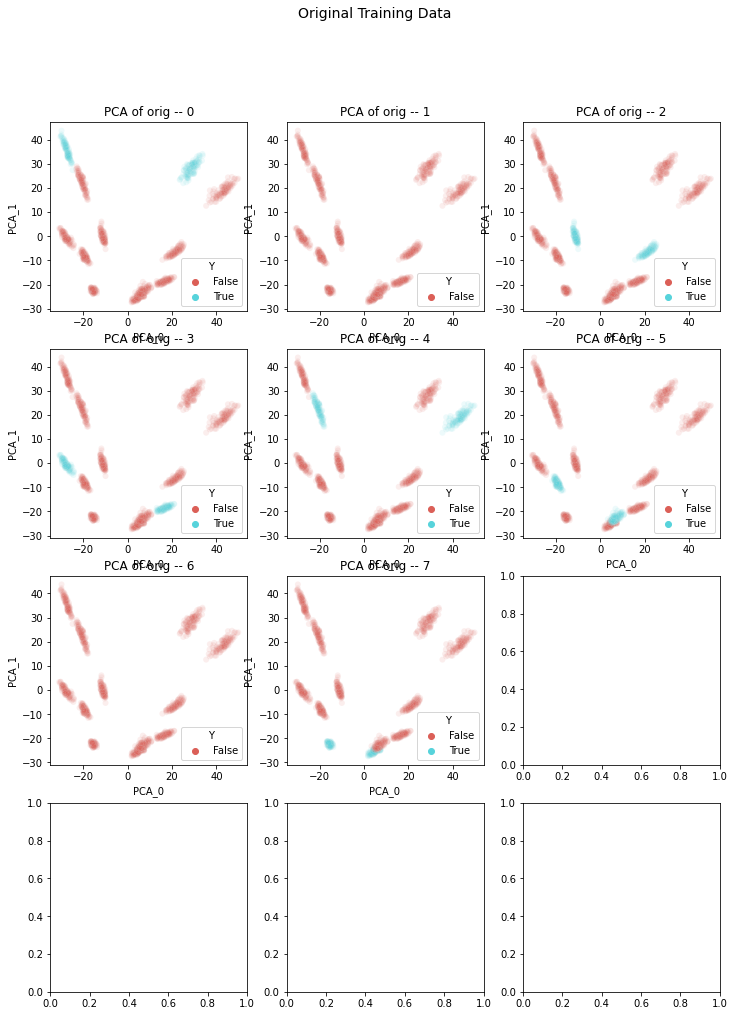

In [20]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=label_num==0, ax=axs[0,0], title="PCA of orig -- 0")
vp.plot_pca(plot_df, color_vec=label_num==1, ax=axs[0,1], title="PCA of orig -- 1")
vp.plot_pca(plot_df, color_vec=label_num==2, ax=axs[0,2], title="PCA of orig -- 2")
vp.plot_pca(plot_df, color_vec=label_num==3, ax=axs[1,0], title="PCA of orig -- 3")
vp.plot_pca(plot_df, color_vec=label_num==4, ax=axs[1,1], title="PCA of orig -- 4")
vp.plot_pca(plot_df, color_vec=label_num==5, ax=axs[1,2], title="PCA of orig -- 5")
vp.plot_pca(plot_df, color_vec=label_num==6, ax=axs[2,0], title="PCA of orig -- 6")
vp.plot_pca(plot_df, color_vec=label_num==7, ax=axs[2,1], title="PCA of orig -- 7")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(1200, 2)
(1200, 2)


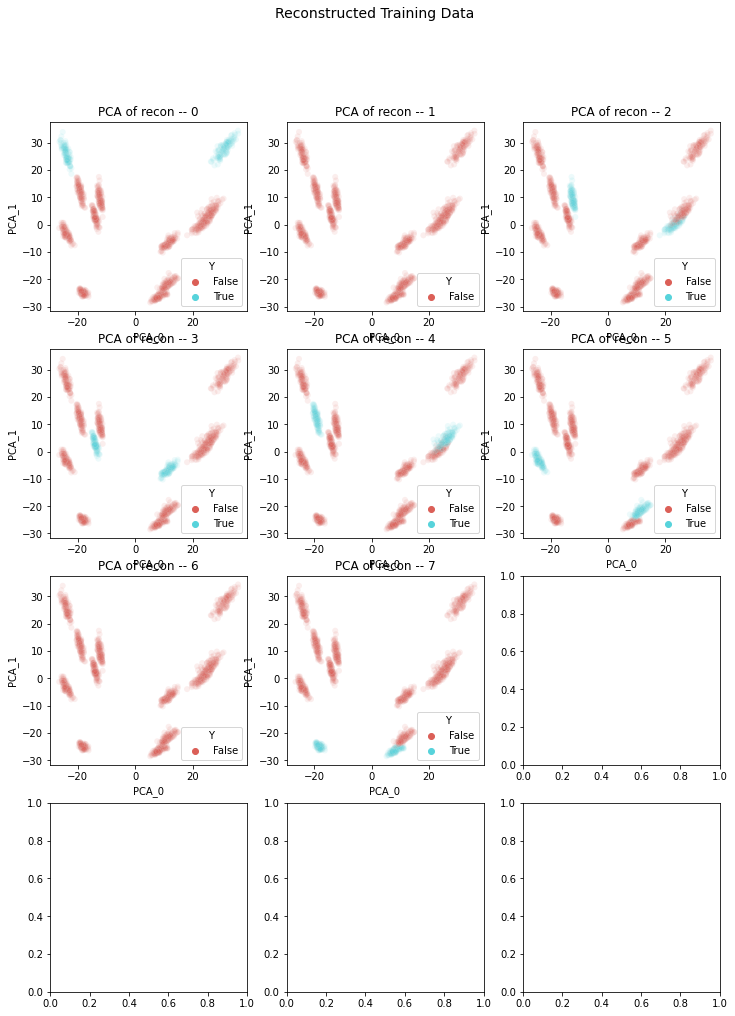

In [21]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=label_num==0, ax=axs[0,0], title="PCA of recon -- 0")
vp.plot_pca(plot_df, color_vec=label_num==1, ax=axs[0,1], title="PCA of recon -- 1")
vp.plot_pca(plot_df, color_vec=label_num==2, ax=axs[0,2], title="PCA of recon -- 2")
vp.plot_pca(plot_df, color_vec=label_num==3, ax=axs[1,0], title="PCA of recon -- 3")
vp.plot_pca(plot_df, color_vec=label_num==4, ax=axs[1,1], title="PCA of recon -- 4")
vp.plot_pca(plot_df, color_vec=label_num==5, ax=axs[1,2], title="PCA of recon -- 5")
vp.plot_pca(plot_df, color_vec=label_num==6, ax=axs[2,0], title="PCA of recon -- 6")
vp.plot_pca(plot_df, color_vec=label_num==7, ax=axs[2,1], title="PCA of recon -- 7")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

(2400, 2)
(2400, 2)


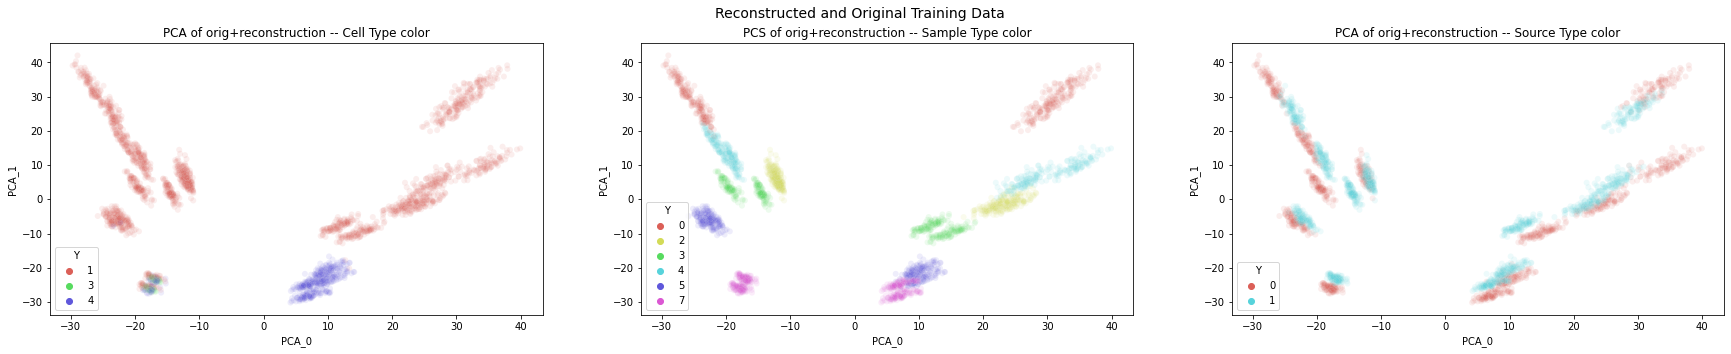

In [22]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])


Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*1200, [1]*1200))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

## Do latent space projectsions

### drug perturbation

In [23]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)


<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [24]:

# run first the cell_type specific things

cell_type_specific_r2 = None
cell_type_specific_real = None
cell_type_specific_proj = None
meta_DESeq = None
all_samps = ['101', '1016', '1039', '107', '1244', '1488']


sc_proj_meta_df, decoded_0_0, decoded_0_1 = vp.calc_PCA_perturbation(X_full, meta_df, scaler, fit)
decoded_0_1 = np.clip(decoded_0_1, 0, clip_upper)
decoded_0_0 = np.clip(decoded_0_0, 0, clip_upper)

for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, decoded_0_0, 
                                                                                        decoded_0_1, scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, sc_proj_meta_df,
                                                                                        curr_cell_type)

        expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                        'expr_r2', 'log2FC_r2',
                                                        'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse'])

        curr_meta = {'sample_id':[curr_samp]*(proj_stim.shape[0]*2),
                     'cell_type':[curr_cell_type]*(proj_stim.shape[0]*2),
                     'cond':['ctrl']*(proj_stim.shape[0]) + ['stim']*(proj_stim.shape[0])}
        curr_meta = pd.DataFrame(curr_meta)
        curr_DESeq_real = np.append(real_ctrl, real_stim, axis=0)
        curr_DESeq_proj = np.append(proj_ctrl, proj_stim, axis=0)

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
            meta_DESeq = curr_meta
            cell_type_specific_real = curr_DESeq_real
            cell_type_specific_proj = curr_DESeq_proj
        else:
             cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])
             meta_DESeq = pd.concat([meta_DESeq, curr_meta])
             cell_type_specific_real = np.append(cell_type_specific_real, curr_DESeq_real, axis=0)
             cell_type_specific_proj = np.append(cell_type_specific_proj, curr_DESeq_proj, axis=0)



# now run the realistic ones

101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1039
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
107
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1244
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1488
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


In [25]:
real_ctrl.shape


(100, 7066)

In [26]:
cell_type_specific_r2

,sample_id,cell_type,bulk_type,expr_r2,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse
0,101,B,cell_type_specific,0.599796,0.448661,0.356201,0.622950,0.477417,2.394066
0,101,CD14_Mono,cell_type_specific,0.728526,0.341249,0.215591,0.444271,0.432112,3.044559
0,101,CD16_Mono,cell_type_specific,0.659238,0.446540,0.287935,0.595820,0.480178,2.356167
0,101,CD4_Mem_T,cell_type_specific,0.621936,0.442840,0.363195,0.636221,0.498143,2.407126
0,101,CD4_Naive_T,cell_type_specific,0.489063,0.438079,0.381330,0.625832,0.497755,2.405803
0,101,CD8_T,cell_type_specific,0.564290,0.443560,0.348101,0.629061,0.495655,2.396381
0,101,DC,cell_type_specific,0.594988,0.443546,0.346529,0.563091,0.399280,2.342652
0,101,Mk,cell_type_specific,0.448239,0.458739,0.311544,0.613449,0.499251,2.383081
0,101,NK,cell_type_specific,0.534259,0.441148,0.329324,0.631109,0.503644,2.388340
0,101,T_Act,cell_type_specific,0.570352,0.439056,0.350023,0.604497,0.453285,2.401372


In [27]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_PCA.csv")
cell_type_specific_r2.to_csv(pearson_res_file, index=False)


## Diff expr

In [28]:
de_proj = pd.DataFrame(cell_type_specific_proj, columns = union_genes)
de_real = pd.DataFrame(cell_type_specific_real, columns = union_genes)

de_proj = de_proj.apply(np.ceil)
de_proj = de_proj.apply(pd.to_numeric)

de_real = de_real.apply(np.ceil)
de_real = de_real.apply(pd.to_numeric)



de_proj

,7SK.2,A2M,A2M-AS1,A4GALT,AAAS,AAED1,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM8,ZW10,ZWILCH,ZXDC,ZYX,ZZZ3,hsa-mir-8072
0,0.0,24.0,22.0,55.0,0.0,701.0,256.0,0.0,1448.0,382.0,...,42.0,0.0,0.0,0.0,97.0,146.0,112.0,1086.0,361.0,58.0
1,0.0,30.0,23.0,65.0,0.0,856.0,275.0,0.0,1573.0,405.0,...,47.0,0.0,0.0,0.0,110.0,151.0,125.0,1173.0,386.0,62.0
2,0.0,25.0,21.0,56.0,0.0,780.0,243.0,0.0,1456.0,379.0,...,41.0,0.0,0.0,0.0,95.0,143.0,113.0,1117.0,364.0,57.0
3,0.0,38.0,23.0,71.0,0.0,936.0,271.0,0.0,1614.0,411.0,...,49.0,1.0,0.0,0.0,114.0,155.0,134.0,1245.0,403.0,65.0
4,0.0,31.0,24.0,67.0,0.0,871.0,278.0,0.0,1583.0,410.0,...,48.0,0.0,0.0,0.0,113.0,152.0,130.0,1188.0,394.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,3.0,29.0,22.0,98.0,380.0,1157.0,545.0,0.0,2448.0,71.0,...,116.0,0.0,288.0,79.0,186.0,34.0,245.0,1716.0,0.0,0.0
11996,3.0,23.0,16.0,88.0,325.0,1119.0,472.0,2.0,2448.0,21.0,...,106.0,0.0,303.0,77.0,165.0,20.0,235.0,1745.0,0.0,0.0
11997,2.0,18.0,18.0,82.0,314.0,947.0,489.0,0.0,2384.0,15.0,...,103.0,0.0,262.0,64.0,159.0,18.0,219.0,1595.0,0.0,0.0
11998,4.0,38.0,21.0,111.0,402.0,1372.0,531.0,36.0,2448.0,84.0,...,119.0,0.0,334.0,95.0,195.0,37.0,267.0,1887.0,0.0,4.0


In [29]:
de_real

,7SK.2,A2M,A2M-AS1,A4GALT,AAAS,AAED1,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM8,ZW10,ZWILCH,ZXDC,ZYX,ZZZ3,hsa-mir-8072
0,0.0,0.0,0.0,0.0,1266.0,152.0,469.0,1016.0,1049.0,7.0,...,0.0,42.0,509.0,5.0,21.0,319.0,0.0,113.0,0.0,311.0
1,0.0,0.0,0.0,0.0,1731.0,156.0,495.0,856.0,1133.0,22.0,...,0.0,20.0,539.0,6.0,186.0,470.0,0.0,100.0,0.0,340.0
2,0.0,0.0,0.0,0.0,1298.0,171.0,490.0,590.0,1122.0,3.0,...,0.0,92.0,426.0,43.0,13.0,244.0,0.0,98.0,0.0,336.0
3,0.0,0.0,0.0,4.0,1867.0,169.0,391.0,983.0,827.0,2.0,...,0.0,61.0,411.0,9.0,10.0,343.0,0.0,106.0,0.0,315.0
4,5.0,0.0,0.0,4.0,1470.0,165.0,430.0,817.0,1096.0,6.0,...,0.0,4.0,520.0,21.0,24.0,280.0,0.0,128.0,0.0,282.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,1.0,0.0,0.0,12.0,47.0,645.0,6.0,241.0,47.0,...,6.0,0.0,0.0,3.0,3.0,8.0,31.0,53.0,1048.0,0.0
11996,0.0,0.0,0.0,0.0,12.0,23.0,739.0,0.0,223.0,28.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,1251.0,0.0
11997,0.0,0.0,0.0,0.0,6.0,40.0,631.0,0.0,141.0,39.0,...,0.0,3.0,0.0,0.0,0.0,1.0,7.0,97.0,1431.0,0.0
11998,0.0,0.0,0.0,0.0,6.0,67.0,904.0,7.0,347.0,35.0,...,0.0,3.0,0.0,3.0,3.0,0.0,5.0,199.0,1143.0,0.0


In [30]:
meta_DESeq.cell_type.unique()

array(['B', 'CD14_Mono', 'CD16_Mono', 'CD4_Mem_T', 'CD4_Naive_T', 'CD8_T',
       'DC', 'Mk', 'NK', 'T_Act'], dtype=object)

In [31]:
b_idx = np.where(meta_DESeq.cell_type == "CD14_Mono")[0]
de_proj_b = de_proj.iloc[b_idx,]
meta_DESeq_b = meta_DESeq.iloc[b_idx,]

new_index = ["samp_" + str(s) for s in range(len(b_idx))]
de_proj_b.index = new_index
meta_DESeq_b.index = new_index


dds_proj_B = DeseqDataSet(
    counts=de_proj_b,
    clinical=meta_DESeq_b,
    design_factors=["cond", "sample_id"],
    refit_cooks=True
)

In [32]:
dds_proj_B.deseq2()

Fitting size factors...
... done in 0.23 seconds.

Fitting dispersions...
... done in 6.21 seconds.

Fitting dispersion trend curve...
... done in 3.20 seconds.



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan


Fitting MAP dispersions...
... done in 6.96 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 5.09 seconds.

Refitting 43 outliers.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.05 seconds.



In [33]:
b_proj_res = DeseqStats(dds_proj_B, contrast=["cond", "ctrl", "stim"])


In [34]:
b_proj_res.summary()

Running Wald tests...
... done in 3.35 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7SK.2,3.038901,0.308036,0.047344,6.506279,7.703506e-11,1.017169e-10
A2M,24.618043,-0.122660,0.016732,-7.330797,2.287882e-13,3.154797e-13
A2M-AS1,9.004609,-0.019580,0.051150,-0.382787,7.018779e-01,7.110283e-01
A4GALT,64.923201,0.101422,0.042927,2.362681,1.814328e-02,1.980520e-02
AAAS,210.913366,0.026304,0.011307,2.326246,2.000542e-02,2.180411e-02
...,...,...,...,...,...,...
ZWILCH,45.169929,1.897608,0.099674,19.038145,8.239456e-81,2.926399e-80
ZXDC,134.227327,-0.575090,0.057532,-9.995954,1.587514e-23,2.597181e-23
ZYX,692.572795,2.169618,0.116327,18.651015,1.239022e-77,4.225877e-77
ZZZ3,261.695877,0.085998,0.005806,14.812348,1.219063e-49,2.922348e-49


In [35]:
de_real_b = de_real.iloc[b_idx,]
de_real_b.index = new_index


dds_real_B = DeseqDataSet(
    counts=de_real_b,
    clinical=meta_DESeq_b,
    design_factors=["cond", "sample_id"],
    refit_cooks=True
)

dds_real_B.deseq2()

b_real_res = DeseqStats(dds_real_B, contrast=["cond", "ctrl", "stim"])

b_real_res.summary()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 3.24 seconds.

Fitting dispersion trend curve...
... done in 3.22 seconds.

Fitting MAP dispersions...
... done in 3.08 seconds.

Fitting LFCs...
... done in 4.76 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 3.43 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7SK.2,26.635519,1.812351,0.253134,7.159665,8.087469e-13,1.198682e-12
A2M,1.964113,0.429174,0.179191,2.395058,1.661774e-02,1.904794e-02
A2M-AS1,0.838261,0.018072,0.221257,0.081681,9.349008e-01,9.389161e-01
A4GALT,45.637010,3.958553,0.126100,31.392230,2.583044e-216,1.864203e-215
AAAS,86.496637,2.062411,0.077204,26.713905,3.245067e-157,1.740378e-156
...,...,...,...,...,...,...
ZWILCH,18.466306,0.373275,0.108273,3.447532,5.657324e-04,6.876820e-04
ZXDC,131.633574,-0.861172,0.116570,-7.387613,1.494880e-13,2.245521e-13
ZYX,900.188266,1.245835,0.055037,22.636500,1.895065e-113,7.631389e-113
ZZZ3,55.931625,-1.585827,0.108924,-14.559003,5.119886e-48,1.157088e-47


In [36]:
a = np.array(b_proj_res.results_df.log2FoldChange)
b = b_real_res.results_df.log2FoldChange
nas = np.logical_or(np.isnan(a), np.isnan(b))
pearsonr(a[~nas], b[~nas])


(0.3846475110741869, 1.8143456834526545e-245)

In [37]:
b_real_res = b_real_res.results_df
b_proj_res = b_proj_res.results_df

In [38]:
b_real_res = b_real_res.sort_values(by=['log2FoldChange'])
a = b_real_res.iloc[np.where(np.abs(b_real_res.log2FoldChange) > 3)[0]]
len(a)

384

In [39]:
b_proj_res = b_proj_res.sort_values(by=['log2FoldChange'])
a = b_proj_res.iloc[np.where(np.abs(b_proj_res.log2FoldChange) > 3)[0]]

a.index.to_list()

['TRERNA1',
 'SMPD2',
 'MATR3',
 'KIAA0020',
 'ZNF444',
 'RAI14',
 'VMA21',
 'PIM1',
 'PSMD1',
 'TM9SF4',
 'TUBA1A',
 'RIN3',
 'SUN2',
 'DDX50',
 'SNRNP35',
 'ATF7IP',
 'SRP72',
 'EFCAB14',
 'GPI',
 'SEC16A',
 'IRGQ',
 'RNASE6',
 'C10orf32',
 'RP11-345P4.9',
 'MED11',
 'IFNGR1',
 'PGD',
 'C9orf114',
 'CXCL1',
 'SLC2A6',
 'SSR3',
 'SNAPC5',
 'C21orf33',
 'UFD1L',
 'ADAR',
 'GUSB',
 'THEMIS2',
 'TARS',
 'NDUFA6',
 'AKAP8L',
 'CSF1R',
 'SSR4',
 'NCF2',
 'C1orf131',
 'SHMT2',
 'NOL7',
 'ASPH',
 'IFRD1',
 'KRT10',
 'TMEM102',
 'MED8',
 'KIAA0907',
 'GSK3B',
 'ST6GALNAC4',
 'MORN2',
 'RNF125',
 'SRSF9',
 'CEP170',
 'RELA',
 'CCDC23',
 'CTNNBIP1',
 'APP',
 'RNF168',
 'RHBDD2',
 'MAFG',
 'RHOH',
 'TMEM138',
 'FAM127B',
 'SIKE1',
 'NOP10',
 'CMPK1',
 'GGA1',
 'ACADVL',
 'C14orf182',
 'BTF3L4',
 'UBAC2',
 'ARIH2',
 'WDR45',
 'NSFL1C',
 'STRAP',
 'TBC1D20',
 'EIF4E',
 'CYFIP1',
 'BABAM1',
 'ARHGAP18',
 'VIMP',
 'HSD17B4',
 'RPN2',
 'RBM47',
 'IL1B',
 'CCDC130',
 'MRPS6',
 'DESI2',
 'DPH3',
 'CST6